<a href="https://colab.research.google.com/github/Daniele-Di-Bella/ER_glycoforms_fates_modelling/blob/main/ER_Glycoforms_Fates_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General imports. Run always this cell

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# **Glycoforms fates model**

## **Conditions**
### **Entities**
- **Single N-glycan per protein**: the model doesn't account for proteins with multiple glycosylation sites;

- **The model represents glycoforms as a finite list of labelled species**  

- **Lectin-bound species are represented as separate species prefixed by `CNX_` or `OS9_`**: `X` ≠ `CNX_X` ≠ `OS9_X`.

- **No spatial compartments beyond ER lumen and a single `SEC` pool.** There is no Golgi compartment modelled; `SEC` is an accumulating sink that stands for secreted material (presumably reaching Golgi and beyond). No compartment-specific kinetics or transport delays are modelled.

### **Conservation and algebraic constraints**
- **Initial condition: all M9 and kifunensine inhibition.** We are imagining a scenario in which the synthesis of new protein in the cell has been inhibited through the use of kifunensine, therefore, the total tracked mass (1.0 µM) does not vary. Moreover, in this scenario the total tracked mass is initially composed only by proteins possessing the glycoform `M9`, which will have different fates. That's why all concentrations start at 0 µM except `M9 = 1.0 µM`.

- **CNX and OS9 total pools are conserved and treated algebraically.**: lectin pools are fixed totals; binding/unbinding only redistributes between free and bound forms, and total CNX/OS9 never changes.

- **Degraded mass is derived, not a tracked species.** The code computes `total = free_sum + CNX_sum + OS9_sum + SEC` and then `degraded = 1.0 - total`. There is no explicit `DEG` state variable in the ODEs. Degraded mass is whatever has left the tracked pools.

### **Kinetic laws and enzyme modelling**
- **All reactions are mass-action style and linear in substrate; enzyme effects are modelled by multiplying a fixed enzyme pool by a rate constant.** Each enzymatic step is `v = enzyme_pool * k_constant * [substrate]`. There is no explicit enzyme–substrate complex, no saturation, and no cooperative kinetics. Enzyme concentration scales reaction rates linearly.

- **Enzyme abundances are constant parameters (not dynamic).** Enzymes `UGGT, GII, ERManI, EDEM1, EDEM2, EDEM3, EREM` are provided as fixed µM pools in `params`. They do not change during simulation. Enzyme regulation, synthesis, degradation or sequestration are not included; simulated perturbations are implemented by setting k constants to zero.

- **UGGT and GII select free species only.** UGGT/GII actions are restricted to the `free` pool, so CNX-bound or OS9-bound glycoforms are not glucosylated or deglycosylated.

- **ERManI and EDEM2 target N-glycan branch B; EDEM1 and EDEM3 target branches A and C.** Multiple mannosidases can catalyze overlapping transformations but with different rate constants.

- **ER-EM acts on glucosylated species (G1...) and directly converts them to trimmed non-glucosylated products.** The recent publication of [this paper](https://pubmed.ncbi.nlm.nih.gov/41100884/) pushed us to take into account the presence of an additional enzyme called with the general name ER-EM (Endoplasmic Reticulum EndoMannosidase), `EREM`, in the code. `EREM` is modelled as a free enzyme that directly hydrolyses glucosylated glycans in a single step. There is no explicit mechanistic coupling (e.g., complex formation) between UGGT and EREM in the code.

### **Secretion and sinks**
- **Secretion applies only to free glycoforms and with equal rate constant.** The code loops over `free` and applies `v_sec = k_secretion * [s]`, removing it from each free species and adding to `SEC`. There is no dependence on glycoform identity: all free species have the same per-concentration secretion probability. Species-specific secretion signals or lectin protection from secretion (except indirectly via their concentration being in bound pools) are not modelled; secretion is purely concentration-driven for the free pool.

- **ERAD sink acts only on OS9-bound species.** There is no sink on free species or CNX-bound species; only `OS9_<s>` loses mass via `k_ERAD_sink`. OS9 binding is the gate to degradation; escaping OS9 or failing to bind can result in secretion or further trimming instead.

### **Solver assumptions**
- **Numerical integration is performed with `solve_ivp`.** The solver is expected to handle stiff-ish dynamics but there is no explicit solver selection. The time insterval considered, `t_eval`, is a log-spaced vector from `t_start = 1e0` to `t_end = 1e5`. The integration interval passed to the solver starts at `0.0` but `t_eval` avoids t=0 to allow a log x-axis. The log-spaced output emphasizes early-time dynamics.
  
### **Experimental perturbations implemented in the code**
- **Four experimental conditions (A–D) are implemented by zeroing rate constants.**  
  - **A: Uninhibited** — baseline params.  
  - **B: UGGT inhibited** — all `k_UGGT_...` rate constants set to `0.0`. This zeroes glucosylation rates (UGGT catalytic constants), effectively removing UGGT activity. The code leaves `UGGT` pool unchanged but makes its catalytic constants zero.  
  - **C: Mannosidases inhibited** — all keys starting with `k_ERManI_`, `k_EDEM1_`, `k_EDEM2_`, `k_EDEM3_`, and `k_EREM_` set to `0.0` (ERManI/EDEM family and EREM are disabled).  
  - **D: UGGT + Mannosidases inhibited** — merges B and C: UGGT and all ERManI/EDEM/EREM constants are zero.

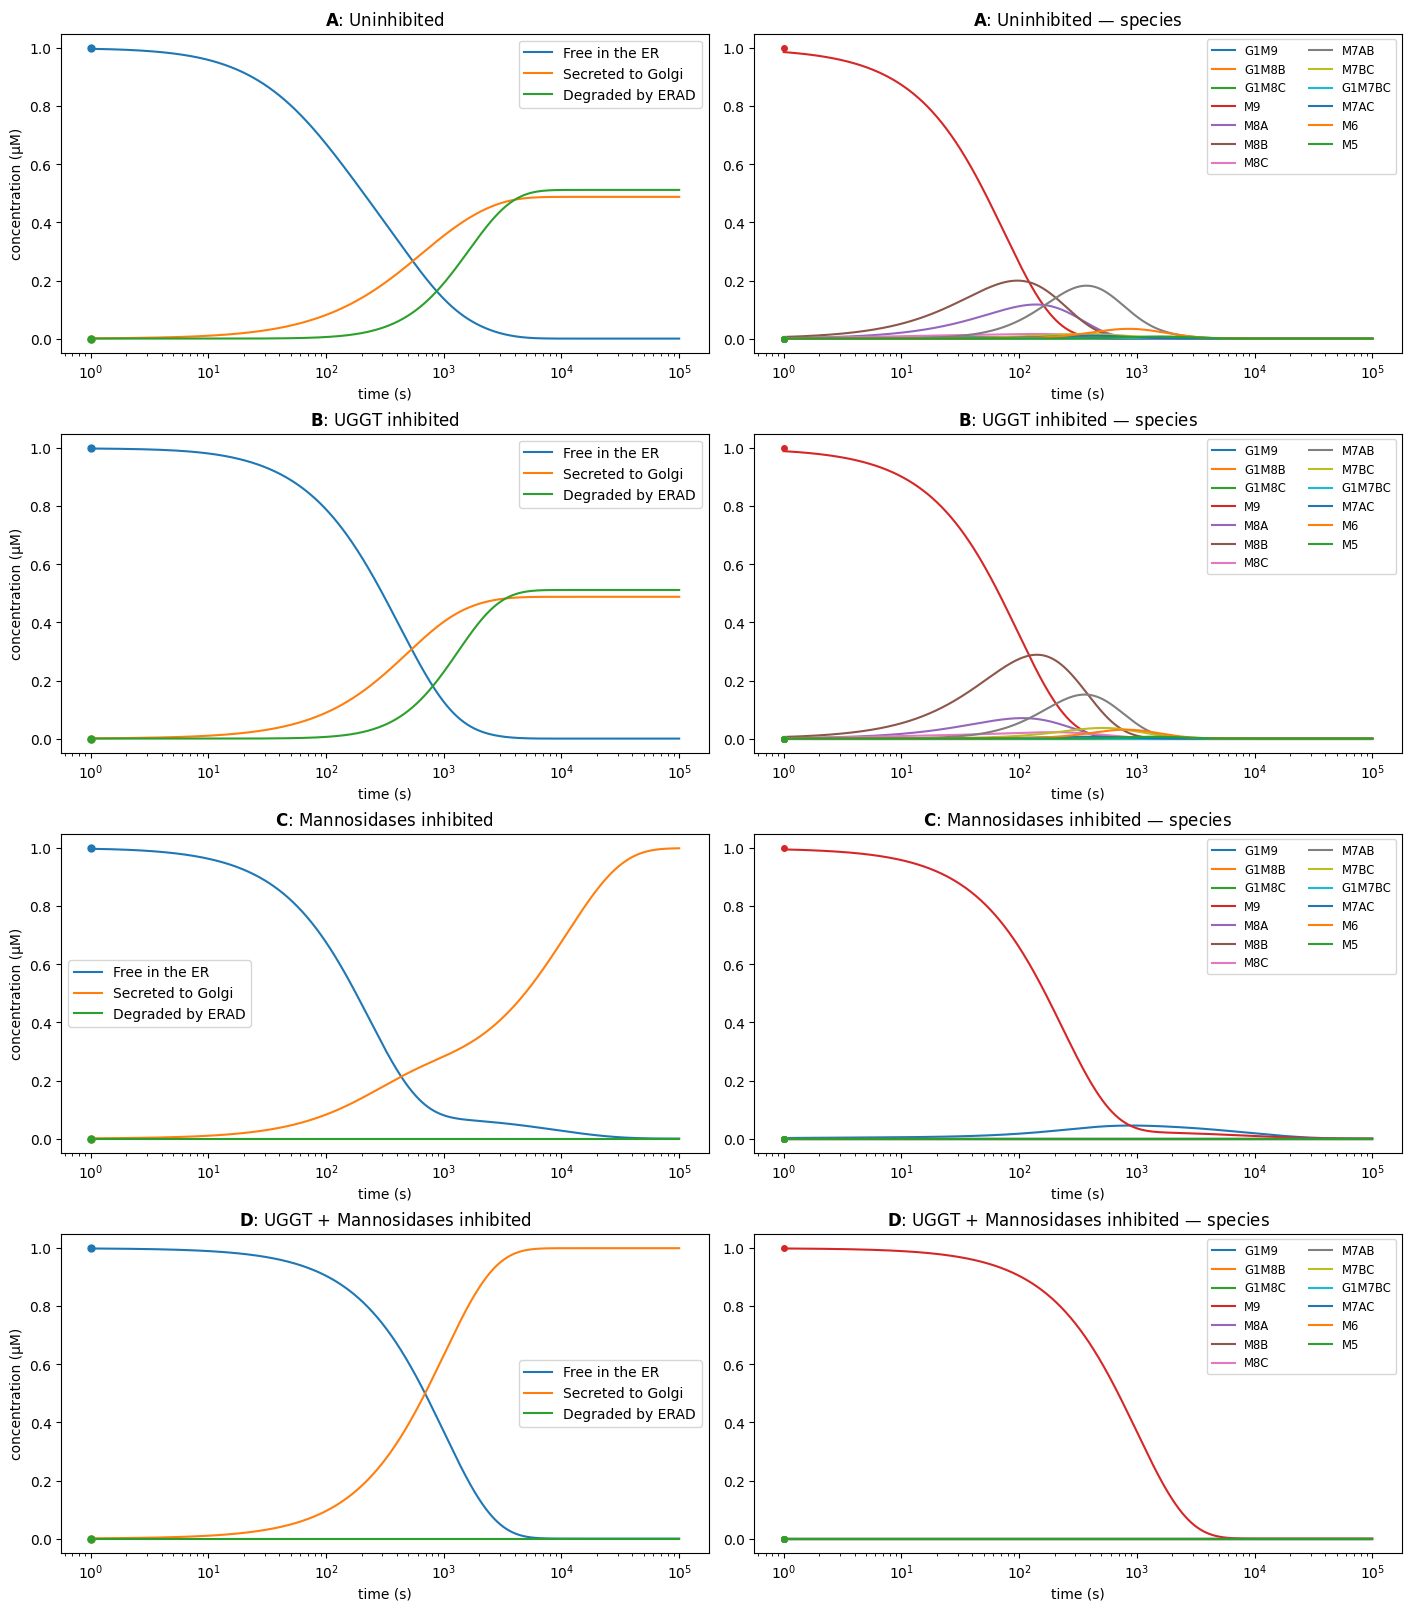

In [ ]:
# ----------------------------
# 1) Initialization
# ----------------------------

# ----------------------------
# 1a) Context
# ----------------------------

# All the glycospecies that can be found on proteins free in the ER lumen
free = ["G1M9","G1M8B","G1M8C","M9","M8A","M8B","M8C", "M7AB","M7BC","G1M7BC","M7AC","M6","M5"]

# CNX-binding species
cnx_bind = ["G1M9","G1M8B","G1M8C","G1M7BC"]

# OS9-binding species
os9_bind = ["M8C","M7AC","M7BC","M6","M5","G1M8C","G1M7BC"]

# Everything that can be found in ER lumen (according to previous initializations)
full_ER = (
    free                              # free glycoproteins
    + [f"CNX_{s}" for s in cnx_bind]  # glycoproteins bound to CNX -> ERQC
    + [f"OS9_{s}" for s in os9_bind]  # glycoproteins bound to OS9 -> ERAD
    + ["SEC"]                         # accumulated secreted pool
)
name_to_index = {n:i for i,n in enumerate(full_ER)}

# ----------------------------
# 1b) Initial condition and parameters
# ----------------------------

# Initial condition: Everything is set on 0 µM except from [M9] = 1.0 µM
y0 = np.zeros(len(full_ER), dtype=float)
y0[name_to_index["M9"]] = 1.0

# Parameters
params = {
    # enzyme pools (µM)
    "UGGT": 0.2, "GII": 0.5, "EREM": 0.75, "ERManI": 0.4,
    "EDEM1": 0.15, "EDEM2": 0.15, "EDEM3": 0.15,
    "CNX_tot": 3.0, "OS9_tot": 0.8,

    # binding kinetics (M^-1 * s^-1, s^-1)
    "kon_CNX": 0.3, "koff_CNX": 0.05,
    "kon_OS9": 0.2, "koff_OS9": 0.03,

    # sinks and secretion (s^-1)
    "k_ERAD_sink": 0.001,
    "k_secretion": 0.001,

    # UGGT (adds glucose, M^-1 s^-1)
    "k_UGGT_G1M9": 0.016, "k_UGGT_G1M8B": 0.016,
    "k_UGGT_G1M8C": 0.016, "k_UGGT_G1M7BC": 0.016,

    # GII (removes glucose, M^-1 s^-1)
    "k_GII_M9": 0.004, "k_GII_M8B": 0.004,
    "k_GII_M8C": 0.004, "k_GII_M7BC": 0.004,

    # ERManI (acts on N-glycan Branch B, M^-1 s^-1)
    "k_ERManI_M8B": 0.012, "k_ERManI_G1M8B": 0.012,
    "k_ERManI_M7BC": 0.012, "k_ERManI_G1M7BC": 0.012,
    "k_ERManI_M7AB": 0.012, "k_ERManI_M6": 0.012,

    # EDEM2 (acts on N-glycan Branch B, M^-1 s^-1)
    "k_EDEM2_M8B": 0.006, "k_EDEM2_G1M8B": 0.006,
    "k_EDEM2_M7BC": 0.006, "k_EDEM2_G1M7BC": 0.006,
    "k_EDEM2_M7AB": 0.006, "k_EDEM2_M6": 0.006,

    # EDEM1 (acts on N-glycan Branches A and C, M^-1 s^-1)
    "k_EDEM1_M8A": 0.006, "k_EDEM1_M7AB": 0.006,
    "k_EDEM1_M6_from_M7BC": 0.006, "k_EDEM1_M7AC": 0.006,
    "k_EDEM1_M5": 0.006, "k_EDEM1_M8C": 0.006,
    "k_EDEM1_M7BC": 0.006, "k_EDEM1_M6_from_M7AB": 0.006,
    "k_EDEM1_M7AC_from_M8A": 0.006,

    # EDEM3 (acts on N-glycan Branches A and C, M^-1 s^-1)
    "k_EDEM3_M8A": 0.006, "k_EDEM3_M7AB": 0.006,
    "k_EDEM3_M6_from_M7BC": 0.006, "k_EDEM3_M7AC": 0.006,
    "k_EDEM3_M5": 0.006, "k_EDEM3_M8C": 0.006,
    "k_EDEM3_M7BC": 0.006, "k_EDEM3_M6_from_M7AB": 0.006,
    "k_EDEM3_M7AC_from_M8A": 0.006,

    # EREM (acts on Glu-Man bonds, µM^-1 s^-1)
    "k_EREM_M8A": 0.2,     # G1M9 -> M8A
    "k_EREM_M7AB": 0.02,    # G1M8B -> M7AB
    "k_EREM_M7AC": 0.02,    # G1M8C -> M7AC
    "k_EREM_M6": 0.02,   # G1M7BC -> M6
}

# ----------------------------
# 2) ODE system
# ----------------------------
def ode_rhs(t: float, y: np.ndarray, p: dict) -> np.ndarray:
    dy = np.zeros_like(y)
    g = lambda s: y[name_to_index[s]]  # gets the index of an item and locate it in y
    add = lambda s, v: dy.__setitem__(name_to_index[s], dy[name_to_index[s]] + v)  # add a value to a certain element in dy

    # Free lectin pools (algebraic approach)
    CNX_free = p["CNX_tot"] - sum(g(f"CNX_{s}") for s in cnx_bind)
    OS9_free = p["OS9_tot"] - sum(g(f"OS9_{s}") for s in os9_bind)

    # CNX binding/unbinding
    for s in cnx_bind:
        bind = p["kon_CNX"] * g(s) * CNX_free
        unbd = p["koff_CNX"] * g(f"CNX_{s}")
        add(s, -bind + unbd)
        add(f"CNX_{s}", +bind - unbd)

    # OS9 binding/unbinding + ERAD sink from OS9‐bound
    for s in os9_bind:
        bind = p["kon_OS9"] * g(s) * OS9_free
        unbd = p["koff_OS9"] * g(f"OS9_{s}")
        erad = p["k_ERAD_sink"] * g(f"OS9_{s}")
        add(s, -bind + unbd)
        add(f"OS9_{s}", +bind - unbd - erad)

    # Secretion of free glycoproteins (equal probability for all free glycoforms)
    ksec = p.get("k_secretion", 0.0)
    if ksec > 0:
        for s in free:
            v_sec = ksec * g(s)
            add(s, -v_sec)
            add("SEC", +v_sec)

    # Enzymatic transformations (UGGT, GII, mannosidases, EREM etc.)
    UGGT = p["UGGT"]; GII = p["GII"]
    ERManI = p["ERManI"]; EDEM1 = p["EDEM1"]
    EDEM2 = p["EDEM2"]; EDEM3 = p["EDEM3"]
    EREM = p.get("EREM", 0.0)

    def bi(pool, k): return pool * k

    # UGGT steps (glucosylation of free forms)
    v = bi(UGGT, p["k_UGGT_G1M9"]) * g("M9");           add("M9",-v);    add("G1M9",+v)
    v = bi(UGGT, p["k_UGGT_G1M8B"]) * g("M8B");         add("M8B",-v);   add("G1M8B",+v)
    v = bi(UGGT, p["k_UGGT_G1M8C"]) * g("M8C");         add("M8C",-v);   add("G1M8C",+v)
    v = bi(UGGT, p["k_UGGT_G1M7BC"]) * g("M7BC");       add("M7BC",-v);  add("G1M7BC",+v)

    # GII steps (deglycosylation of free glucosylated forms)
    v = bi(GII, p["k_GII_M9"]) * g("G1M9");             add("G1M9",-v);  add("M9",+v)
    v = bi(GII, p["k_GII_M8B"]) * g("G1M8B");           add("G1M8B",-v); add("M8B",+v)
    v = bi(GII, p["k_GII_M8C"]) * g("G1M8C");           add("G1M8C",-v); add("M8C",+v)
    v = bi(GII, p["k_GII_M7BC"]) * g("G1M7BC");         add("G1M7BC",-v);add("M7BC",+v)

    # EREM-catalyzed conversions (on free glucosylated species)
    if EREM > 0:
        # 1) G1M9 -> M8A
        v = bi(EREM, p["k_EREM_M8A"]) * g("G1M9");    add("G1M9",-v);  add("M8A",+v)
        # 2) G1M8B -> M7AB
        v = bi(EREM, p["k_EREM_M7AB"]) * g("G1M8B");  add("G1M8B",-v); add("M7AB",+v)
        # 3) G1M8C -> M7AC
        v = bi(EREM, p["k_EREM_M7AC"]) * g("G1M8C");  add("G1M8C",-v); add("M7AC",+v)
        # 4) G1M7BC -> M6
        v = bi(EREM, p["k_EREM_M6"]) * g("G1M7BC"); add("G1M7BC",-v);add("M6",+v)

    # Branch B (ERManI, EDEM2)
    for pool, pref in [(ERManI, "k_ERManI_"), (EDEM2, "k_EDEM2_")]:
        v = bi(pool, p[pref + "M8B"]) * g("M9");          add("M9",-v);    add("M8B",+v)
        v = bi(pool, p[pref + "G1M8B"]) * g("G1M9");      add("G1M9",-v);  add("G1M8B",+v)
        v = bi(pool, p[pref + "M7BC"]) * g("M8C");        add("M8C",-v);   add("M7BC",+v)
        v = bi(pool, p[pref + "G1M7BC"]) * g("G1M8C");    add("G1M8C",-v); add("G1M7BC",+v)
        v = bi(pool, p[pref + "M7AB"]) * g("M8A");        add("M8A",-v);   add("M7AB",+v)
        v = bi(pool, p[pref + "M6"]) * g("M7AC");         add("M7AC",-v);  add("M6",+v)

    # Branch A & C (EDEM1, EDEM3)
    for pool, pref in [(EDEM1, "k_EDEM1_"), (EDEM3, "k_EDEM3_")]:
        v = bi(pool, p[pref + "M8A"]) * g("M9");                          add("M9",-v);    add("M8A",+v)
        v = bi(pool, p[pref + "M7AB"]) * g("M8B");                        add("M8B",-v);   add("M7AB",+v)
        v = bi(pool, p[pref + "M6_from_M7BC"]) * g("M7BC");               add("M7BC",-v);  add("M6",+v)
        v = bi(pool, p[pref + "M7AC"]) * g("M8C");                        add("M8C",-v);   add("M7AC",+v)
        v = bi(pool, p[pref + "M5"]) * g("M6");                           add("M6",-v);    add("M5",+v)
        v = bi(pool, p[pref + "M8C"]) * g("M9");                          add("M9",-v);    add("M8C",+v)
        v = bi(pool, p[pref + "M7BC"]) * g("M8B");                        add("M8B",-v);   add("M7BC",+v)
        v = bi(pool, p[pref + "M6_from_M7AB"]) * g("M7AB");               add("M7AB",-v);  add("M6",+v)
        v = bi(pool, p[pref + "M7AC_from_M8A"]) * g("M8A");               add("M8A",-v);   add("M7AC",+v)

    return dy

def residuals(t: float, y: np.ndarray, p: dict) -> np.ndarray:
    return -ode_rhs(t, y, p)

# ----------------------------
# 3) ODE solver
# ----------------------------
def run_case(pmod: dict, t_end: float = 1e5):
    p = params.copy()
    p.update(pmod or {})

    # Note: solve_ivp uses two time grids.
    # 1) Internal adaptive steps (chosen automatically for accuracy and stability).
    # 2) t_eval points (chosen by the user) where results are interpolated and returned.
    # The solver computes dy/dt at many internal points, not only at t_eval times.
    # Avoid t=0 in t_eval because we use a log x-axis; still integrate from 0
    t_start = 1e-0
    t_eval = np.logspace(np.log10(t_start), np.log10(t_end), 1001, dtype=float)

    sol = solve_ivp(lambda t, y: ode_rhs(t, y, p), (0.0, t_eval[-1]), y0, t_eval=t_eval,
                    rtol=1e-6, atol=1e-9)

    # sums
    CNX_sum = np.sum(sol.y[[name_to_index[f"CNX_{s}"] for s in cnx_bind], :], axis=0)
    OS9_sum = np.sum(sol.y[[name_to_index[f"OS9_{s}"] for s in os9_bind], :], axis=0)
    free_sum = np.sum(sol.y[[name_to_index[s] for s in free], :], axis=0)
    SEC = sol.y[name_to_index["SEC"], :]

    # Total glycoprotein mass tracked
    total = free_sum + CNX_sum + OS9_sum + SEC

    # Degraded = initial total (1.0) - total remaining
    degraded = 1.0 - total

    return sol.t, free_sum, SEC, degraded, sol.y

# ----------------------------
# 4) Plotting (left: aggregate; right: species)
# ----------------------------
def plot_aggregated(ax, t, free_curve, sec_curve, deg_curve, title, t_marker=1e-0):
    line_free, = ax.plot(t, free_curve, label="Free in the ER")
    line_sec, = ax.plot(t, sec_curve, label="Secreted to Golgi")
    line_deg, = ax.plot(t, deg_curve, label="Degraded by ERAD")

    # show true t=0 initial values as small markers (using y0)
    init_free = sum(y0[name_to_index[s]] for s in free)
    init_sec = y0[name_to_index["SEC"]]
    init_degraded = 1.0 - (init_free + init_sec)  # CNX/OS9 complexes are initially zero
    ax.plot(t_marker, init_free, "o", color=line_free.get_color(), markersize=5, zorder=10)  # zorder=10 means "draw this on top of everything else"
    ax.plot(t_marker, init_sec, "o", color=line_sec.get_color(), markersize=5, zorder=10)
    ax.plot(t_marker, init_degraded, "o", color=line_deg.get_color(), markersize=5, zorder=10)

    ax.set_title(title)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("concentration (µM)")
    ax.set_xscale("log")
    ax.legend(loc="best")

def plot_species(ax, t, sol_y, species_list, title, t_marker=1e-0):
    for s in species_list:
        line, = ax.plot(t, sol_y[name_to_index[s], :], label=s)
        # plot t~0 marker for each species from y0
        init_val = float(y0[name_to_index[s]])
        ax.plot(t_marker, init_val, "o", color=line.get_color(), markersize=4, zorder=10)

    ax.set_title(title + " — species")
    ax.set_xlabel("time (s)")
    ax.set_xscale("log")
    ax.legend(loc="best", ncol=2, fontsize="small")

# ----------------------------
# 5) Conditions and run
# ----------------------------
conds = [
    (r"$\bf{A}$: Uninhibited", {}),  # baseline
    (r"$\bf{B}$: UGGT inhibited", {k:0.0 for k in ["k_UGGT_G1M9","k_UGGT_G1M8B","k_UGGT_G1M8C","k_UGGT_G1M7BC"]}),
    (r"$\bf{C}$: Mannosidases inhibited", {k:0.0 for k in [k for k in params.keys() if k.startswith("k_ERManI_") or k.startswith("k_EDEM1_")
    or k.startswith("k_EDEM2_") or k.startswith("k_EDEM3_") or k.startswith("k_EREM_")]}),
    (r"$\bf{D}$: UGGT + Mannosidases inhibited", {})  # will fill below
]

# prepare D (merge B and C)
UGGT_zero = {k:0.0 for k in ["k_UGGT_G1M9","k_UGGT_G1M8B","k_UGGT_G1M8C","k_UGGT_G1M7BC"]}
ERM_keys = [k for k in params.keys() if k.startswith("k_ERManI_") or k.startswith("k_EDEM1_") or k.startswith("k_EDEM2_")
            or k.startswith("k_EDEM3_") or k.startswith("k_EREM_")]
ERM_zero = {k:0.0 for k in ERM_keys}
conds[3] = (r"$\bf{D}$: UGGT + Mannosidases inhibited", {**UGGT_zero, **ERM_zero})

# run all conditions
results = []
for title, pmod in conds:
    t, free_sum, SEC, degraded, sol_y = run_case(pmod)
    results.append((title, t, free_sum, SEC, degraded, sol_y))

# ----------------------------
# 6) Make the 4x2 figure
# ----------------------------
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16), constrained_layout=True)

for row_idx, (title, t, free_sum, SEC, degraded, sol_y) in enumerate(results):
    ax_left = axes[row_idx, 0]
    ax_right = axes[row_idx, 1]

    # left: aggregated curves
    plot_aggregated(ax_left, t, free_sum, SEC, degraded, title)

    # right: species-level (plot 13 free glycoforms)
    plot_species(ax_right, t, sol_y, free, title)

plt.show()
